In [1]:
# macro do ipython para rederizar o matplotlib inline
%matplotlib inline

# numpy é uma biblioteca de python que 
# nos permite fazer operações matriciais e vetoriais
# facilmente, e eficientemente (até um certo tamanho)
import numpy as np

import matplotlib.pyplot as plt

### Objetivo

O objetivo desse jupyter notebook é complementar a aula teórica com uma perspectiva prática do assunto.
Vamos implementar o método dos mínimos quadrados em numpy para ficarmos mais familiares com essa biblioteca e também com o numpy.

In [2]:
class RegressaoLinear(object):

    def __init__(self):
        self.w_ = None
    
    def ajustar(self, X, y):
        return self
    
    def predizer(self, X):
        if self.w_ is None:
            raise ValueError('Tentando predizer sem ajustar aos dados!!!') 
            
        n_exemplos, n_atributos = X.shape
        
        # expandimos X para ascrecentando uma coluna de 1's
        # para o w_0 que representa onde o hiperplano
        # corta o eixo y
        X = np.hstack((np.ones((n_exemplos, 1)), X))
            
        return X.dot(self.w_)


Esse é o esqueleto de nossa classe que ajustas os dados usando um regressão linear. Vamos então implementar o método para ajustar aos dados (encontrar o w) utilizando o método dos mínimos quadrados visto em aula.

Lembra-se que há uma fórmula analítica para resolvermos o problema de minímzação da soma das diferenças $\min_{w} ||Xw - y||^2_2$ que é definida do seguinte modo:

$w = (X^TX)^{-1}X^Ty$

Como vamos implementar isso? Vou ter de fazer todos essas operações matriciais? Vou ter de implementar um algoritmo para calcular a inversa de uma matriz?

É aí que entra o numpy! Ele nos oferece todas essas operações implementadas eficientemente em C (por de baixo dos panos) para possamos fazer chamadas bem alto nível e consigamos implementar o método dos mínimos quadrados sem muito esforço.

Então como que fica isso em python + numpy?

In [3]:
class RegressaoLinearMMQ(RegressaoLinear):
    
    def ajustar(self, X, y):
        n_exemplos, n_atributos = X.shape
        
        if y.ndim == 1:
            y = y[:, np.newaxis]
        
        # expandimos X para ascrecentando uma coluna de 1's
        # para o w_0 que representa onde o hiperplano
        # corta o eixo y
        X = np.hstack((np.ones((n_exemplos, 1)), X))
        
        self.w_ = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        return self

Isso mesmo, simples assim! 

Vamos só explicar algumas cosinhas que podem parecer estranhas no primeiro momento.

```python
if y.ndim == 1:
    y = y[:, np.newaxis]
```

O trecho de código acima garante que $y$ seja um vetor no formato $Nx1$, ou seja, colunar.

Para explicar o trecho a seguir precisamos recapitular umas cosinhas da aula.

```python
# expandimos X para ascrecentando uma coluna de 1's
# para o w_0 que representa onde o hiperplano
# corta o eixo y
X = np.hstack((np.ones((n_exemplos, 1)), X))
```

Lembram-se que nós temos $n\_atributos + 1$ pesos, onde o primeiro peso o $w_0$ é a interseção da reta com o eixo $y$? Lembram-se que a fórmula genérica para nossos modelos lineares é $y = w_0 * 1 + w_1 * x_1 + ... + w_m * x_m$?

Desse modo, para achar o peso $w_0$ precisamos acrescentar uma variável "arficial" que sempre vai ter o valor 1.
Portanto, é para isso que serve o código acima, para acrescentar essa variável e nos permitir achar o $w_0$!

### Testando nossa implementação

Vamos testar nossa implementação em um conjunto de dados. Para isso vamos utilizar um banco de dados disponibilizado pela biblioteca de aprendizado de máquinas scikit-learn.

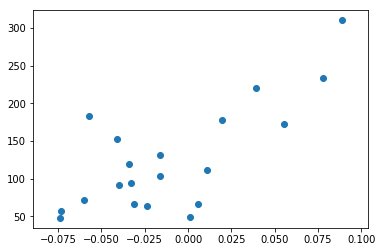

In [7]:
from sklearn import datasets, linear_model

# Carregando o cojunto de dados sobre diabetes
diabetes = datasets.load_diabetes()

# Vamos utilizar apenas um atributo para facilitar nossa visualização
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Vamos pegar apenas umas 20 amostras
X_amostra = diabetes_X[-20:]
y_amostra = diabetes.target[-20:]

plt.scatter(X_amostra, y_amostra)

Bora treinar nosso modelo com nossa implementação :)

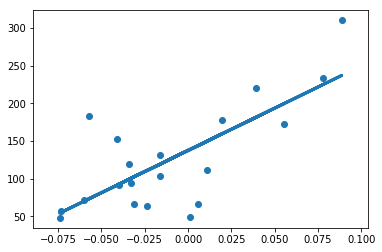

In [5]:
reg = RegressaoLinearMMQ()
reg.ajustar(X_amostra, y_amostra)

plt.scatter(X_amostra, y_amostra)
plt.plot(X_amostra, reg.predizer(X_amostra),
         linewidth=3)

Olha gente que lindo! Nossa regressão linear funcionou. Vamos contrastar nossa implementação com o do scikit-learn.

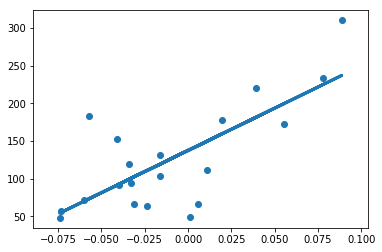

In [9]:
reg = linear_model.LinearRegression()
reg.fit(X_amostra, y_amostra)

plt.scatter(X_amostra, y_amostra)
plt.plot(X_amostra, reg.predict(X_amostra),
         linewidth=3)

Obtivemos o mesmo resultado! Quem precisa de scikit-learn agora?? Bricadeira...

Vamos ascrecentar um outlier nesse conjunto de dados e verificar como esse método se comporta.

## Sensibilidade a Outliers

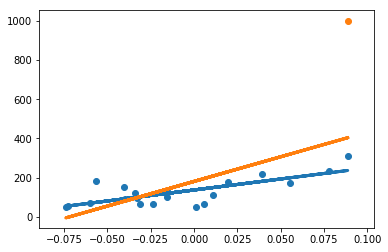

In [22]:
order = np.argsort(X_amostra, 0).ravel()

# vamos adicionar um exemplo com y muito discrepande
# e x igual ao maior valor do conjunto de dados
X_outlier = np.vstack((X_amostra, [[X_amostra.max()]]))
y_outlier = np.concatenate((y_amostra, [1000]))


reg = RegressaoLinearMMQ()

reg.ajustar(X_amostra, y_amostra)
# traçando os pontos e reta anterior
plt.scatter(X_amostra, y_amostra)
plt.plot(X_amostra, reg.predizer(X_amostra),
         linewidth=3)

reg.ajustar(X_outlier, y_outlier)
# traçando o outlier e a nova reta
plt.scatter(X_outlier[-1:], y_outlier[-1:])
plt.plot(X_outlier, reg.predizer(X_outlier),
         linewidth=3)

## Lasso

Brinque um pouco com parâmetro **alpha** do Lasso. A medida que você vai aumentando seu valor, maior é o impacto da penalização do regularizador na otimização dos pesos.

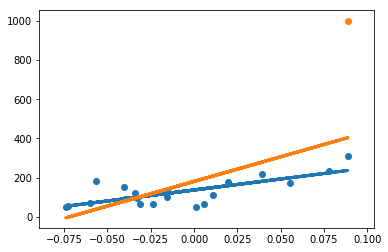

In [48]:
lasso = linear_model.Lasso(alpha=0.001)

reg.ajustar(X_amostra, y_amostra)
# traçando os pontos e reta anterior
plt.scatter(X_amostra, y_amostra)
plt.plot(X_amostra, reg.predizer(X_amostra),
         linewidth=3)

lasso.fit(X_outlier, y_outlier)
# traçando o outlier e a nova reta
plt.scatter(X_outlier[-1:], y_outlier[-1:])
plt.plot(X_outlier, lasso.predict(X_outlier),
         linewidth=3)